In [29]:
# importing libraries
# %matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from os import listdir
warnings.filterwarnings('ignore')

foldername = '2023-02-12-100Hz'


all_files = listdir('Dataset/' + foldername)
csv_files = list(filter(lambda f: f.endswith('.csv'), all_files))

df_har = pd.DataFrame()

for name in csv_files:
    # reading raw data file
    columns = ['time','Ax-axis','Ay-axis', 'Az-axis', 'TgF', 'Gait']
    df_har_tmp = pd.read_csv('Dataset/' + foldername + '/' + name, names = columns, error_bad_lines=False)  # type: ignore


    n = 200
    df_har_tmp = df_har_tmp.head(-n)
    df_har_tmp = df_har_tmp.tail(-n)

    if 'abnormal' in name.lower():
        df_har_tmp['Gait'] = 'abnormal'
    else:
        df_har_tmp['Gait'] = 'normal'

    # removing null values
    df_har_tmp = df_har_tmp.dropna()

    # transforming the x,y,z-axis to float
    df_har_tmp = df_har_tmp.astype({'Ax-axis':'float','Ay-axis':'float', 'Az-axis':'float'})

    print(df_har_tmp.shape)

    df_har = df_har.append(df_har_tmp) #iloc[::5, :])

print(df_har.shape)



(29479, 6)
(5500, 6)
(28858, 6)
(30120, 6)
(29144, 6)
(28675, 6)
(151776, 6)


In [30]:
random_seed = 42   
n_time_steps = 100 
n_features = 3 
step = 10
n_classes = 6 
n_epochs = 200       
batch_size = 1024   
learning_rate = 0.0025
l2_loss = 0.0015

def sgdata(data):

    segments = []
    labels = []

    for i in range(0,  data.shape[0]- n_time_steps, step):

        xs = data['Ax-axis'].values[i: i + n_time_steps]

        ys = data['Ay-axis'].values[i: i + n_time_steps]

        zs = data['Az-axis'].values[i: i + n_time_steps]

        label = stats.mode(data['Gait'][i: i + n_time_steps])[0][0]

        segments.append([xs, ys, zs])

        labels.append(label)

    #reshape the segments which is (list of arrays) to a list
    reshaped_segments = np.asarray(segments).swapaxes(1,2).reshape(-1, n_time_steps, n_features)
    labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)
    return reshaped_segments, labels
reshaped_segments, labels = sgdata(df_har)

In [31]:
print(reshaped_segments.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size = 0.2, random_state = random_seed)

(15168, 100, 3)


In [32]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Dropout

model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5)) 
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               67584     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 2)                 130       
                                                                 
Total params: 75,970
Trainable params: 75,970
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/200
10/10 [==============================] - 14s 1s/step - loss: 0.6605 - accuracy: 0.6109 - val_loss: 0.6426 - val_accuracy: 0.6123
Epoch 2/200
10/10 [==============================] - 11s 1s/step - loss: 0.6192 - accuracy: 0.6558 - val_loss: 0.6471 - val_accuracy: 0.5748
Epoch 3/200
10/10 [==============================] - 10s 975ms/step - loss: 0.6215 - accuracy: 0.6448 - val_loss: 0.6007 - val_accuracy: 0.6625
Epoch 4/200
10/10 [==============================] - 10s 1s/step - loss: 0.5895 - accuracy: 0.6856 - val_loss: 0.5657 - val_accuracy: 0.7256
Epoch 5/200
10/10 [==============================] - 10s 987ms/step - loss: 0.5557 - accuracy: 0.6898 - val_loss: 0.5472 - val_accuracy: 0.6831
Epoch 6/200
10/10 [==============================] - 11s 1s/step - loss: 0.5353 - accuracy: 0.7266 - val_loss: 0.5286 - val_accuracy: 0.7231
Epoch 7/200
10/10 [==============================] - 10s 1s/step - loss: 0.5207 - accuracy: 0.7285 - val_loss: 0.5145 - val_accuracy: 0.7359
Epoch 8

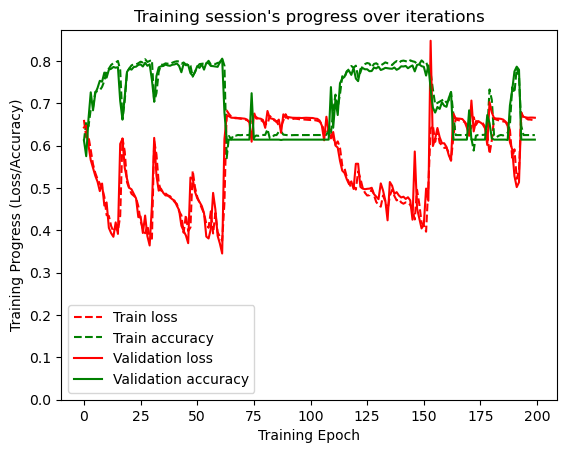

In [33]:
history = model.fit(X_train, y_train, epochs = n_epochs, validation_split = 0.20, batch_size = batch_size, verbose = 1)
plt.plot(np.array(history.history['loss']), "r--", label = "Train loss")
plt.plot(np.array(history.history['accuracy']), "g--", label = "Train accuracy")
plt.plot(np.array(history.history['val_loss']), "r-", label = "Validation loss")
plt.plot(np.array(history.history['val_accuracy']), "g-", label = "Validation accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0) 
plt.show()

In [34]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size = batch_size, verbose = 1)
print("Test Accuracy :", accuracy)
print("Test Loss :", loss)

3/3 [==============================] - 1s 347ms/step - loss: 0.6740 - accuracy: 0.5976
Test Accuracy : 0.5975610017776489
Test Loss : 0.6739658117294312


95/95 [==============================] - 4s 38ms/step


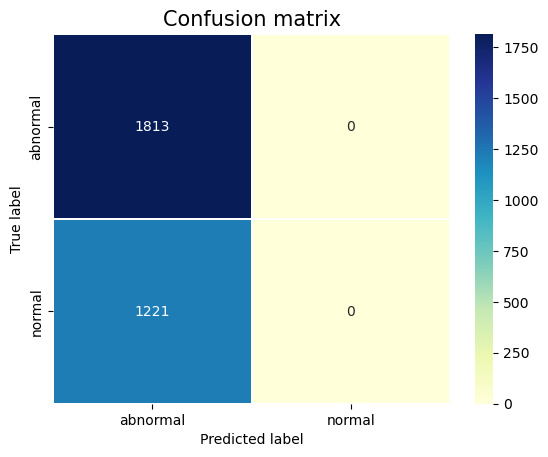

In [35]:
from sklearn import metrics
#from keras.metrics import confusion_matrix
predictions = model.predict(X_test)
class_labels = ['abnormal', 'normal']
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
sns.heatmap(confusion_matrix, xticklabels = class_labels, yticklabels = class_labels, annot = True, linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [36]:
testfile = 'normal 2nd.csv'
columns = ['time','Ax-axis','Ay-axis', 'Az-axis', 'TgF', 'Gait']
testdata = pd.read_csv('Dataset/' + foldername + '/' + testfile, names = columns, error_bad_lines=False)

# clean the data
n = 200
testdata = testdata.tail(-n)
testdata = testdata.head(-n)
if 'abnormal' in testfile.lower():
    testdata['Gait'] = 'abnormal'
else:
    testdata['Gait'] = 'normal'
testdata = testdata.astype({'Ax-axis':'float','Ay-axis':'float', 'Az-axis':'float'})

rstest, labeltest = sgdata(testdata)

prediction = model.predict(rstest)

#print(prediction)

sum1 = 0
sum2 = 0

for i in prediction:
    sum1 += i[0]
    sum2 += i[1]

print("Abnormal: " + str(sum1 / len(prediction)))
print("Normal: " + str(sum2 / len(prediction)))


91/91 [==============================] - 3s 37ms/step
Abnormal: 0.629329031428864
Normal: 0.3706709577171404
